In [31]:
from utils_vae import read_field
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Model
import tensorflow
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf

from sklearn.decomposition import PCA

## Load the high resolution data

In [2]:
path = "/glade/scratch/sshamekh/dyamond/SAM_highres/"

import sys, importlib

from utils_vae import train_test_data
t1 = 0
t2 = 8
high_res = 4.0 # km 
large_scale = 128# 96 km
dim = int(large_scale/high_res)

x_hr,x_lg,y_out = train_test_data(path, high_res,large_scale,t1,t2,threshold_precip = 0.01)

Reading large-scale outputs
pracc
(760, 24, 287, 1)
[[[[0.8208742125920748]]]]
Reading high resolution input
qvi
no scaling
(760, 24, 287, 32, 32, 1)
Reading large-scale inputs
qvi
ts
tas
huss
(760, 24, 287, 4)
Reading large-scale inputs2
nt, nlat, nlon, nxy, nxy, nv_hr: (760, 24, 287, 32, 32, 1)


In [3]:
pw_anomaly= (x_hr - np.mean(x_hr,axis = (1,2),keepdims = True)) 

In [4]:
mask= np.random.rand(x_hr.shape[0])<0.8
x_train_hr,x_test_hr = pw_anomaly[mask,:],pw_anomaly[~mask,:]

x_train_lg,x_test_lg = x_lg[mask,:],x_lg[~mask,:]

y_train_lg,y_test_lg = y_out[mask,:],y_out[~mask,:]

In [8]:
%store x_train_lg
%store y_train_lg
%store x_test_lg
%store y_test_lg

Stored 'x_train_lg' (MaskedArray)
Stored 'y_train_lg' (MaskedArray)
Stored 'x_test_lg' (MaskedArray)
Stored 'y_test_lg' (MaskedArray)


## Get latent representations and decoder weights

In [46]:
nlatent = 2

encoder_weights = '{}nodes_RI/encoder_{}_32_mse_anomaly'.format(nlatent,nlatent)
decoder_weights = '{}nodes_RI/decoder_{}_32_mse_anomaly_v2'.format(nlatent,nlatent)


In [47]:
def make_z(hrdata,encoder_weights):
    encoder_result= keras.models.load_model(encoder_weights,compile=False)
    tt,nx,ny,ff = hrdata.shape
    zall = encoder_result.predict(hrdata)

    return zall

# 2nodes_RI, 4nodes, 4nodes_RI:
z_true = make_z(2*pw_anomaly,encoder_weights)
# 2nodes
#z_true = make_z(pw_anomaly,encoder_weights)

39260/39260 [==============================] - 55s 1ms/step


In [48]:
decode_zz= keras.models.load_model(decoder_weights,compile=False)

## Plot the distributions of latent variables

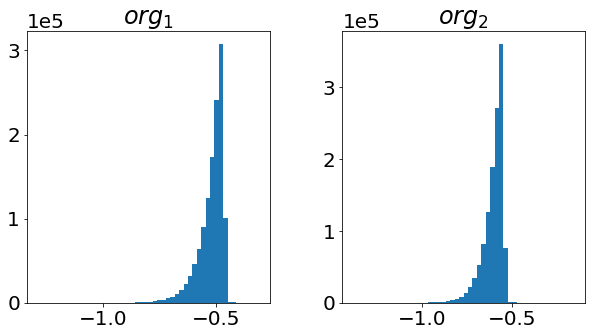

In [49]:
nlatent = 2

fig, axs = plt.subplots(nrows=nlatent//2, ncols=2, figsize=(10,nlatent//2*5))
nbins=50

ax = np.ravel(axs)
norms = False
ax[0].hist(z_true[:,0],bins=nbins,density=norms)
ax[0].set_title(r'$org_{1}$')
ax[0].ticklabel_format(style='sci',scilimits=(-3,3))
ax[1].hist(z_true[:,1],bins=nbins,density=norms)
ax[1].set_title(r'$org_{2}$')
ax[1].ticklabel_format(style='sci',scilimits=(-3,3))

if nlatent>2:
    ax[2].hist(z_true[:,2],bins=nbins,density=norms)
    ax[2].set_title(r'$org_{3}$')
    ax[2].ticklabel_format(style='sci',scilimits=(-3,3))
    ax[3].hist(z_true[:,3],bins=nbins,density=norms)
    ax[3].set_title(r'$org_{4}$')
    ax[3].ticklabel_format(style='sci',scilimits=(-3,3))
plt.tight_layout
plt.rcParams['font.size'] = 20
plt.subplots_adjust(wspace=0.3, hspace=0.4)
#fig.savefig('Decoder_8days_4Nodes_RI_histogram_sciorg_abs.jpeg',bbox_inches = 'tight',dpi = 500)
plt.show()

# Visualize the 2D latent space

In [50]:
# Number of quantiles to visualize
n = 10

aa = np.arange(0,100,n)+5
grid_z = np.zeros((nlatent,n))

for i in range(0,nlatent):
    grid_z[i,:]=np.percentile(z_true[:,i],aa)

z0grid = grid_z[0,:]
z1grid = grid_z[1,:]
if nlatent>2:
    z2val = grid_z[2,5]
    z3val = grid_z[3,5]
else:
    z2val = None
    z3val = None

In [51]:
def plot_latent_images(model, n, nlatent,z0grid,z1grid,z2val=z2val,z3val=z3val,digit_size=28,scale=True):
    """Plots n x n digit images decoded from the latent space."""
    image_size = digit_size+1    
    
    image_width = image_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))
    grid = np.zeros((image_height, image_width))
    
    for i in range(0,n):
        for j in range(0,n):
            
            a = np.zeros([1,nlatent])
            
            a[0,0]=grid_z[0,i]
            a[0,1]=grid_z[1,j]
            if nlatent ==4:
                a[0,2]=z2val
                a[0,3]=z3val
            

            z = K.constant(a)

            x_decoded = model.predict(z);

            print(x_decoded.shape)

            digitmargin = np.zeros((image_size,image_size))

            print(digitmargin.shape)
            if scale:
                digitmargin[0:-1,0:-1] = (x_decoded[0,:,:]-np.min(x_decoded[0,:,:]))/(np.max(x_decoded[0,:,:]-np.min(x_decoded[0,:,:])))
            else:
                digitmargin[0:-1,0:-1] = x_decoded[0,:,:]

            image[i * image_size: (i + 1) * image_size,j * image_size: (j + 1) * image_size] = digitmargin

    return image 

In [52]:
%%capture --no-display
imagegrid = plot_latent_images(decode_zz,n,nlatent,z0grid,z1grid,z2val=z2val,z3val=z3val,digit_size=32,scale=False);

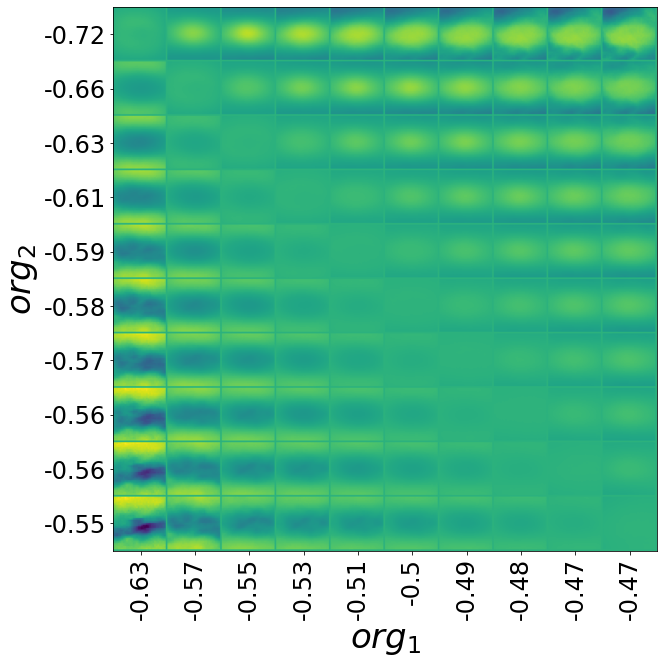

In [54]:
img = imagegrid
fig,ax = plt.subplots(1,figsize=(10, 10))

xlabels = z0grid.round(decimals=2).astype(str)
ylabels = z1grid.round(decimals=2).astype(str)

digit_size = 32
nticks = np.arange(0,10)*((digit_size+1)*10)/10+digit_size/2 # np.arange(0,10)*250/10+12.5

# Show the result
ax.imshow(imagegrid)

ax.set_xlabel(r'$org_{1}$',fontsize=34)
ax.set_ylabel(r'$org_{2}$',fontsize=34)
ax.set_xticks(ticks=nticks,labels=xlabels, rotation=90,fontsize=24)
ax.set_yticks(ticks=nticks,labels=ylabels,fontsize=24)

fig.show()
#fig.savefig('Decoder_8days_2nodes_RI_distribution_absolute_directions.jpeg',bbox_inches = 'tight',dpi = 500)
plt.show()

# Visualize the 4D latent space

In [20]:
n = 6 # number of quantiles

digit_size = 32
aa = np.arange(0,100,100/n)+5

grid_z = np.zeros((nlatent,n))

for i in range(0,nlatent):
    pp = np.percentile(z_true[:,i],aa)
    grid_z[i,:]= pp

z0grid = grid_z[0,:]
z1grid = grid_z[1,:]
if nlatent>2:
    z2val = grid_z[2,n//2]
    z3val = grid_z[3,n//2]
else:
    z2val = None
    z3val = None

In [21]:
imagegrids = np.zeros((n,n,n*(digit_size+1),n*(digit_size+1)))
print(imagegrids.shape)

(6, 6, 198, 198)


In [22]:
%%capture --no-display
z0grid = grid_z[0,i]
z1grid = grid_z[1,i]

for i in range(0,n):
    for j in range(0,n):
        z2val = grid_z[2,i]
        z3val = grid_z[3,j]
        imagegrids[i,j,:,:]=plot_latent_images(decode_zz,n,nlatent,z0grid,z1grid,z2val=z2val,z3val=z3val,digit_size=digit_size,scale=False);

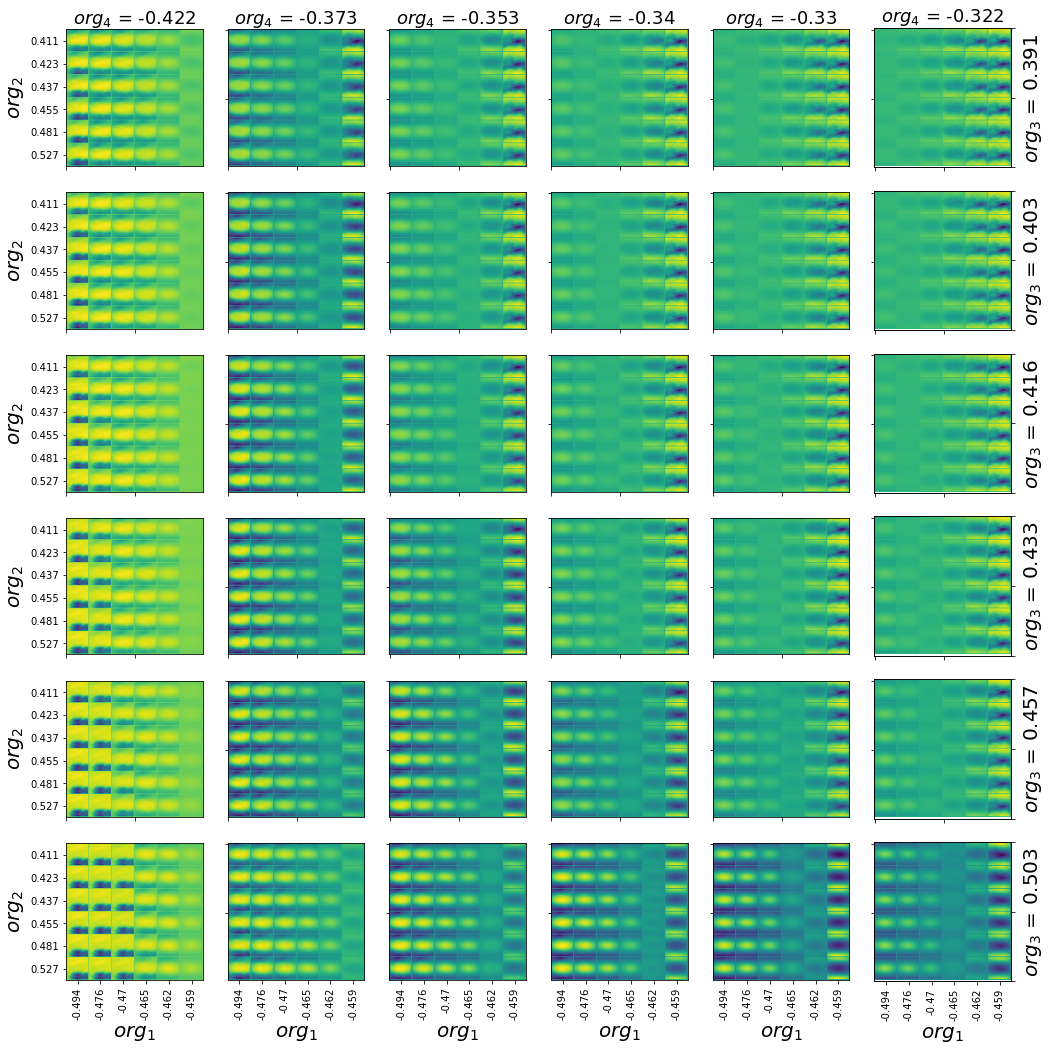

In [23]:
fig,axs = plt.subplots(n,n,figsize=(15,15))

for i in range(0,n):
    for j in range(0,n):
        img = imagegrids[i,j,:,:]
 
        xlabels = grid_z[0,:].round(decimals=3).astype(str)
        ylabels = grid_z[1,:].round(decimals=3).astype(str)

        z2val = np.round(grid_z[2,i],3)
        z3val = np.round(grid_z[3,j],3)
        
        #title = r'$org_{3}$ = '+str(z2val)+",\n"+r'$org_{4}$ = '+str(z3val) 

        axs[i,j].imshow(img)
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])
        axs[i,j].set_aspect('equal')
        #axs[i,j].set_title(title,fontsize=12)
        if j == n-1:
            ax2 = axs[i,j].twinx()
            ax2.set_ylabel(r'$org_{3}$ = '+str(z2val))
            ax2.set_xticklabels([])
            ax2.set_yticklabels([])
            
        if i == 0:
            axs[i,j].set_title(r'$org_{4}$ = '+str(z3val),fontsize=18)
        
        if i == n-1:
            axs[i,j].set_xlabel(r'$org_{1}$')
            axs[i,j].set_xticks(ticks=np.arange(0,n)*(digit_size+1)+(digit_size+1)/2,labels=xlabels,fontsize=10, rotation=90)
        if j == 0:
            axs[i,j].set_ylabel(r'$org_{2}$')
            axs[i,j].set_yticks(ticks=np.arange(0,n)*(digit_size+1)+(digit_size+1)/2,labels=ylabels,fontsize=10)
        
        plt.tight_layout(h_pad=1.0)

fig.savefig('LatentClouds_4nodes_RI_8days_all_6quantiles_org1toorg4_abs.jpeg',bbox_inches = 'tight',dpi = 500)

In [24]:
def plot_latent_images_it(model, n, nlatent,z0grid,z1grid,z2val=z2val,z3val=z3val,it=[0,1,2,3],digit_size=28,scale=True):
    """Plots n x n digit images decoded from the latent space."""
    image_size = digit_size+1    
    
    image_width = image_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))
    grid = np.zeros((image_height, image_width))
    
    for i in range(0,n):
        for j in range(0,n):
            
            a = np.zeros([1,nlatent])
            
            a[0,it[0]]=grid_z[0,i]
            a[0,it[1]]=grid_z[1,j]
            if nlatent ==4:
                a[0,it[2]]=z2val
                a[0,it[3]]=z3val
            

            z = K.constant(a)

            x_decoded = model.predict(z);

            print(x_decoded.shape)

            digitmargin = np.zeros((image_size,image_size))

            print(digitmargin.shape)
            if scale:
                digitmargin[0:-1,0:-1] = (x_decoded[0,:,:]-np.min(x_decoded[0,:,:]))/(np.max(x_decoded[0,:,:]-np.min(x_decoded[0,:,:])))
            else:
                digitmargin[0:-1,0:-1] = x_decoded[0,:,:]

            image[i * image_size: (i + 1) * image_size,j * image_size: (j + 1) * image_size] = digitmargin

    return image 

In [25]:
# Number of quantiles to visualize
n = 10

aa = np.arange(0,100,n)+5
grid_z = np.zeros((nlatent,n))

for i in range(0,nlatent):
    grid_z[i,:]=np.percentile(z_true[:,i],aa)

z0grid = grid_z[2,:]
z1grid = grid_z[3,:]
if nlatent>2:
    z2val = np.percentile(z_true[:,0],50)
    z3val = np.percentile(z_true[:,1],50)
else:
    z2val = None
    z3val = None

In [26]:
%%capture --no-display
imagegrid = plot_latent_images_it(decode_zz,n,nlatent,
                                  z0grid,z1grid,
                                  z2val=z2val,z3val=z3val,
                                  it=[0,1,2,3],
                                  digit_size=32,scale=False);

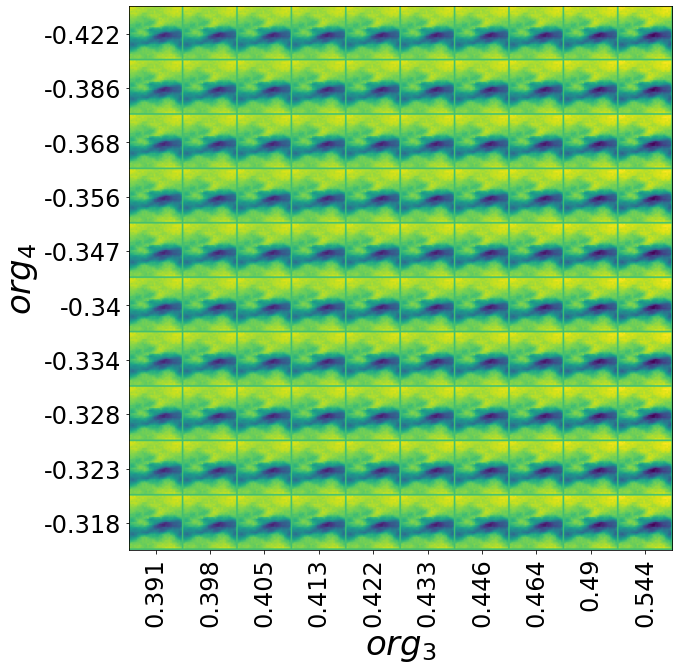

In [29]:
img = imagegrid
n = 10
fig,ax = plt.subplots(1,figsize=(n, n))

xlabels = z0grid.round(decimals=3).astype(str)
ylabels = z1grid.round(decimals=3).astype(str)

digit_size = 32
nticks = np.arange(0,n)*((digit_size+1)*n)/n+digit_size/2 # np.arange(0,10)*250/10+12.5

# Show the result
ax.imshow(imagegrid)

ax.set_xlabel(r'$org_{3}$',fontsize=34)
ax.set_ylabel(r'$org_{4}$',fontsize=34)
ax.set_xticks(ticks=nticks,labels=xlabels, rotation=90,fontsize=24)
ax.set_yticks(ticks=nticks,labels=ylabels,fontsize=24)

fig.show()
#fig.savefig('Decoder_8days_4nodes_distribution_absolute_org3org4.jpeg',bbox_inches = 'tight',dpi = 500)
plt.show()

# Visualization of latent space principal components (2d case)

In [55]:
pca = PCA(n_components = 2)
zp_true = pca.fit_transform(z_true)

In [56]:
aa = np.arange(0,100,n)+5

In [57]:
# Number of quantiles to visualize
n = 10

aa = np.arange(0,100,n)+5
grid_z = np.zeros((nlatent,n))

for i in range(0,nlatent):
    grid_z[i,:]=np.percentile(zp_true[:,i],aa)

z0grid = grid_z[0,:]
z1grid = grid_z[1,:]
if nlatent>2:
    z2val = grid_z[2,5]
    z3val = grid_z[3,5]
else:
    z2val = None
    z3val = None

In [59]:
def plot_latent_images_pca(model, n, nlatent,z0grid,z1grid,pca,z2val=z2val,z3val=z3val,digit_size=28,scale=True):
    """Plots n x n digit images decoded from the latent space."""
    image_size = digit_size+1    
    
    image_width = image_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))
    grid = np.zeros((image_height, image_width))
    
    for i in range(0,n):
        for j in range(0,n):
            
            a = np.zeros([1,nlatent])
            
            a[0,0]=grid_z[0,i]
            a[0,1]=grid_z[1,j]
            if nlatent ==4:
                a[0,2]=z2val
                a[0,3]=z3val
            

            zp = K.constant(a)
            z=pca.inverse_transform(zp)

            x_decoded = model.predict(z);

            print(x_decoded.shape)

            digitmargin = np.zeros((image_size,image_size))

            print(digitmargin.shape)
            if scale:
                digitmargin[0:-1,0:-1] = (x_decoded[0,:,:]-np.min(x_decoded[0,:,:]))/(np.max(x_decoded[0,:,:]-np.min(x_decoded[0,:,:])))
            else:
                digitmargin[0:-1,0:-1] = x_decoded[0,:,:]

            image[i * image_size: (i + 1) * image_size,j * image_size: (j + 1) * image_size] = digitmargin

    return image 

In [60]:
def plot_latent_images_pca_it(model, n, nlatent,z0grid,z1grid,pca,z2val=z2val,z3val=z3val,it=[0,1,2,3],digit_size=28,scale=True):
    """Plots n x n digit images decoded from the latent space."""
    image_size = digit_size+1    
    
    image_width = image_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))
    grid = np.zeros((image_height, image_width))
    
    for i in range(0,n):
        for j in range(0,n):
            
            a = np.zeros([1,nlatent])
            
            a[0,it[0]]=grid_z[0,i]
            a[0,it[1]]=grid_z[1,j]
            if nlatent ==4:
                a[0,it[2]]=z2val
                a[0,it[3]]=z3val
            

            zp = K.constant(a)
            z=pca.inverse_transform(zp)

            x_decoded = model.predict(z);

            print(x_decoded.shape)

            digitmargin = np.zeros((image_size,image_size))

            print(digitmargin.shape)
            if scale:
                digitmargin[0:-1,0:-1] = (x_decoded[0,:,:]-np.min(x_decoded[0,:,:]))/(np.max(x_decoded[0,:,:]-np.min(x_decoded[0,:,:])))
            else:
                digitmargin[0:-1,0:-1] = x_decoded[0,:,:]

            image[i * image_size: (i + 1) * image_size,j * image_size: (j + 1) * image_size] = digitmargin

    return image 

In [61]:
%%capture --no-display
imagegrid = plot_latent_images_pca(decode_zz,n,nlatent,z0grid,z1grid,pca,z2val=z2val,z3val=z3val,digit_size=32,scale=True);

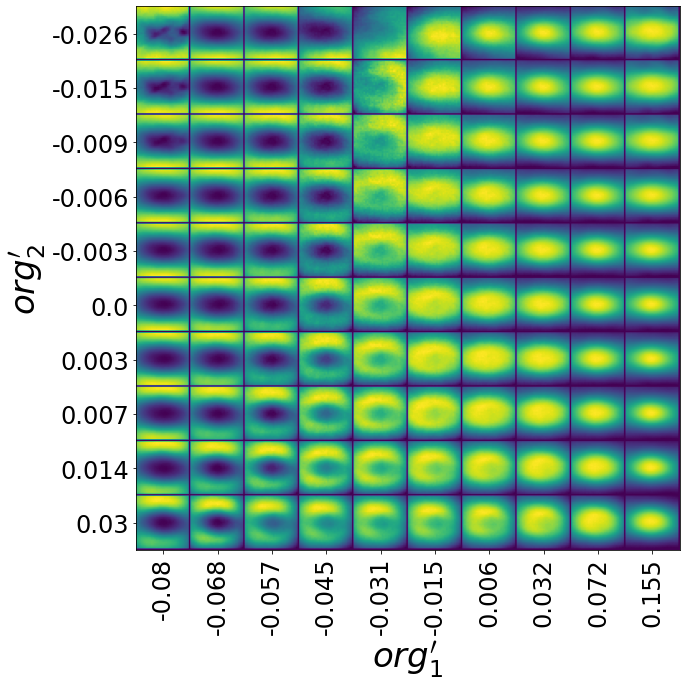

In [63]:
img = imagegrid
n = 10
fig,ax = plt.subplots(1,figsize=(n, n))

xlabels = z0grid.round(decimals=3).astype(str)
ylabels = z1grid.round(decimals=3).astype(str)

digit_size = 32
nticks = np.arange(0,n)*((digit_size+1)*n)/n+digit_size/2 # np.arange(0,10)*250/10+12.5

# Show the result
ax.imshow(imagegrid)

ax.set_xlabel(r'$org_{1}^{\prime}$',fontsize=34)
ax.set_ylabel(r'$org_{2}^{\prime}$',fontsize=34)
ax.set_xticks(ticks=nticks,labels=xlabels, rotation=90,fontsize=24)
ax.set_yticks(ticks=nticks,labels=ylabels,fontsize=24)

fig.show()
#fig.savefig('Decoder_8days_2nodes_notRI_distribution_relative_directions_pcatransformed.jpeg',bbox_inches = 'tight',dpi = 500)
plt.show()

# Visualization of latent space principal components (4d case)

In [38]:
pca = PCA(n_components = 4)
zp_true = pca.fit_transform(z_true)

In [39]:
n = 6 # number of quantiles

digit_size = 32
aa = np.arange(0,100,100/n)+5

grid_z = np.zeros((nlatent,n))

for i in range(0,nlatent):
    pp = np.percentile(zp_true[:,i],aa)
    grid_z[i,:]= pp

z0grid = grid_z[0,:]
z1grid = grid_z[1,:]
if nlatent>2:
    z2val = grid_z[2,n//2]
    z3val = grid_z[3,n//2]
else:
    z2val = None
    z3val = None

In [40]:
imagegrids = np.zeros((n,n,n*(digit_size+1),n*(digit_size+1)))
print(imagegrids.shape)

(6, 6, 198, 198)


In [41]:
%%capture --no-display
z0grid = grid_z[0,i]
z1grid = grid_z[1,i]

for i in range(0,n):
    for j in range(0,n):
        z2val = grid_z[2,i]
        z3val = grid_z[3,j]
        imagegrids[i,j,:,:] = plot_latent_images_pca(decode_zz,n,nlatent,z0grid,z1grid,pca,z2val=z2val,z3val=z3val,digit_size=32,scale=True);

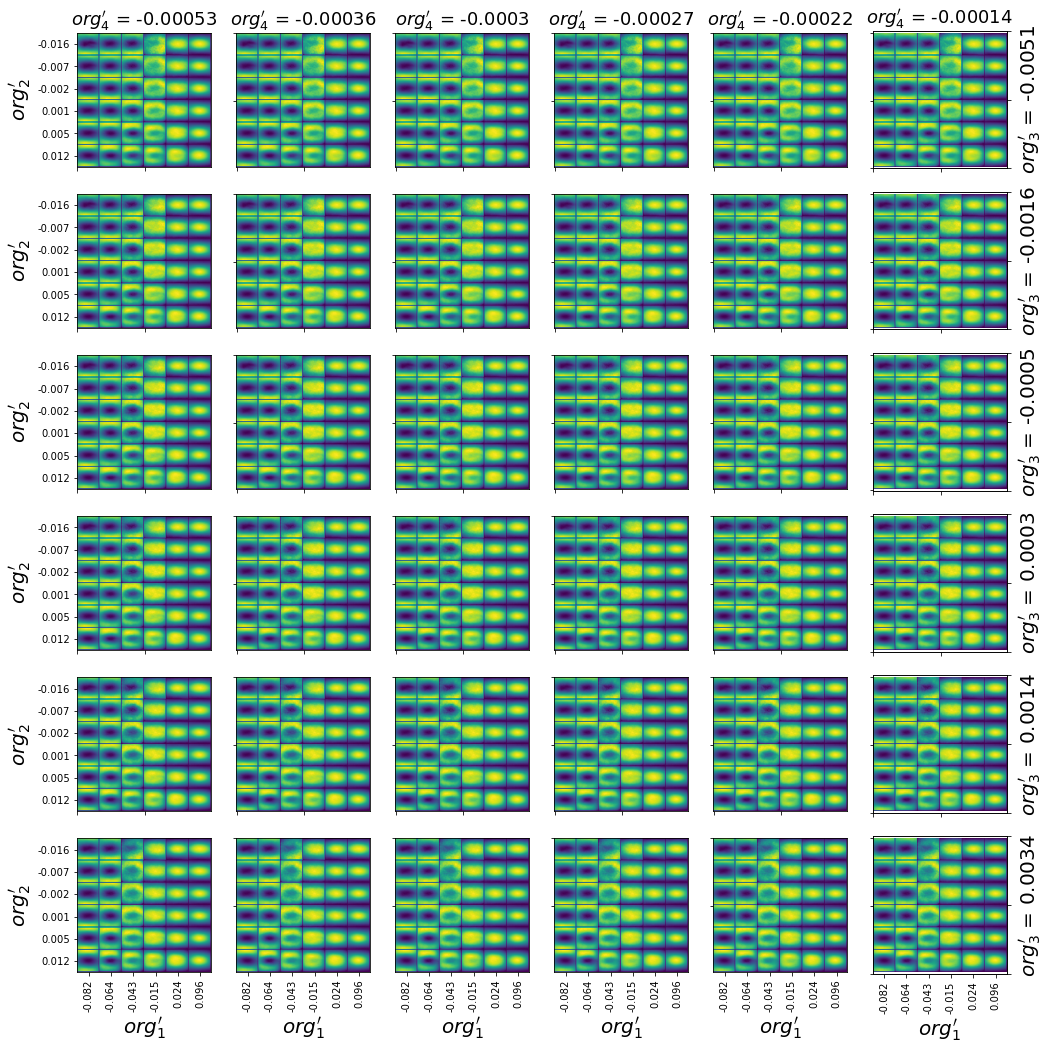

In [42]:
fig,axs = plt.subplots(n,n,figsize=(15,15))

for i in range(0,n):
    for j in range(0,n):
        img = imagegrids[i,j,:,:]
 
        xlabels = grid_z[0,:].round(decimals=3).astype(str)
        ylabels = grid_z[1,:].round(decimals=3).astype(str)

        z2val = np.round(grid_z[2,i],4)
        z3val = np.round(grid_z[3,j],5)
        
        #title = r'$org_{3}$ = '+str(z2val)+",\n"+r'$org_{4}$ = '+str(z3val) 

        axs[i,j].imshow(img)
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])
        axs[i,j].set_aspect('equal')
        #axs[i,j].set_title(title,fontsize=12)
        if j == n-1:
            ax2 = axs[i,j].twinx()
            ax2.set_ylabel(r'$org_{3}^{\prime}$ = '+z2val.astype(str))
            ax2.set_xticklabels([])
            ax2.set_yticklabels([])
            
        if i == 0:
            axs[i,j].set_title(r'$org_{4}^{\prime}$ = '+z3val.astype(str),fontsize=18)
        
        if i == n-1:
            axs[i,j].set_xlabel(r'$org_{1}^{\prime}$')
            axs[i,j].set_xticks(ticks=np.arange(0,n)*(digit_size+1)+(digit_size+1)/2,labels=xlabels,fontsize=10, rotation=90)
        if j == 0:
            axs[i,j].set_ylabel(r'$org_{2}^{\prime}$')
            axs[i,j].set_yticks(ticks=np.arange(0,n)*(digit_size+1)+(digit_size+1)/2,labels=ylabels,fontsize=10)
        
        plt.tight_layout(h_pad=1.0)

fig.show()
#fig.savefig('LatentClouds_4nodes_RI_8days_all_6quantiles_org1ptoorg4p_rel_orgpca.jpeg',bbox_inches = 'tight',dpi = 500)

In [43]:
# Number of quantiles to visualize
n = 10

aa = np.arange(0,100,n)+5
grid_z = np.zeros((nlatent,n))

for i in range(0,nlatent):
    grid_z[i,:]=np.percentile(zp_true[:,i],aa)

z0grid = grid_z[0,:]
z1grid = grid_z[3,:]
if nlatent>2:
    z2val = np.percentile(zp_true[:,1],50)
    z3val = np.percentile(zp_true[:,2],50)
else:
    z2val = None
    z3val = None

In [44]:
%%capture --no-display
imagegrid = plot_latent_images_pca_it(decode_zz,n,nlatent,
                                      z0grid,z1grid,pca,
                                      z2val=z2val,z3val=z3val,
                                      it=[0,3,1,2],
                                      digit_size=32,scale=True);

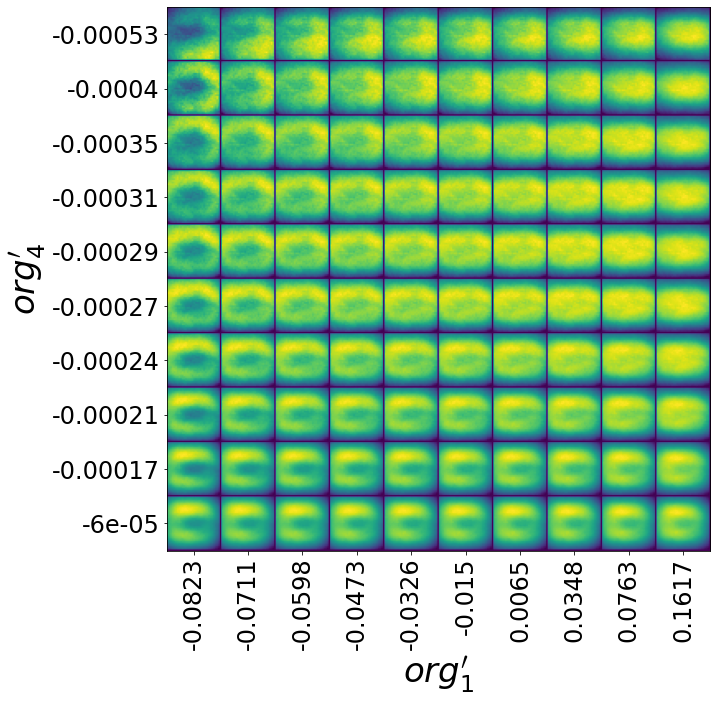

In [45]:
img = imagegrid
n = 10
fig,ax = plt.subplots(1,figsize=(n, n))

xlabels = z0grid.round(decimals=4).astype(str)
ylabels = z1grid.round(decimals=5).astype(str)

digit_size = 32
nticks = np.arange(0,n)*((digit_size+1)*n)/n+digit_size/2 # np.arange(0,10)*250/10+12.5

# Show the result
ax.imshow(imagegrid)

ax.set_xlabel(r'$org_{1}^{\prime}$',fontsize=34)
ax.set_ylabel(r'$org_{4}^{\prime}$',fontsize=34)
ax.set_xticks(ticks=nticks,labels=xlabels, rotation=90,fontsize=24)
ax.set_yticks(ticks=nticks,labels=ylabels,fontsize=24)

fig.show()
#fig.savefig('Decoder_8days_4nodes_distribution_absolute_pcatransformed_orgp1orgp4.jpeg',bbox_inches = 'tight',dpi = 500)
plt.show()